In [1]:
import glob
import random

import numpy as np

from keyrover import *

In [2]:
def plot_corners(d, plot_raw=True, ax=None):
    ax = plt.gca() if ax is None else ax
    
    d[(0, 0)] = np.array(d[(0, 0)])
    d[(0, 1)] = np.array(d[(0, 1)])
    d[(1, 0)] = np.array(d[(1, 0)])
    d[(1, 1)] = np.array(d[(1, 1)])

    imshow(img, ax=ax)
    if plot_raw:
        ax.scatter(*d[(0, 0)].T, color="#fcba03", s=1)
        ax.scatter(*d[(0, 1)].T, color="#fcba03", s=1)
        ax.scatter(*d[(1, 0)].T, color="#fcba03", s=1)
        ax.scatter(*d[(1, 1)].T, color="#fcba03", s=1)

    d[(0, 0)] = d[(0, 0)].mean(axis=0)
    d[(0, 1)] = d[(0, 1)].mean(axis=0)
    d[(1, 0)] = d[(1, 0)].mean(axis=0)
    d[(1, 1)] = d[(1, 1)].mean(axis=0)

    ax.scatter(*d[(0, 0)], color="red", s=3)
    ax.scatter(*d[(0, 1)], color="red", s=3)
    ax.scatter(*d[(1, 0)], color="red", s=3)
    ax.scatter(*d[(1, 1)], color="red", s=3)

    quad = np.array([d[(0, 0)], d[(0, 1)], d[(1, 1)], d[(1, 0)], d[(0, 0)]])
    ax.plot(*quad.T, 'r-')


def in_keyboard(x=slice(None, None), y=slice(None, None)):
    return mask[y, x].sum() > 100


def reduce_gradient(arr, threshold=2):
    arr = arr[mask[y, x]]
    arr = arr[abs(arr) < threshold]
    return arr.mean()


def compute_gradient(arr, x=slice(None, None), y=slice(None, None), grad_filter=2):
    grad = np.gradient(arr[y, x])
    
    if isinstance(grad, np.ndarray) == 1:
        grad = grad[mask[y, x]]
        grad = grad[abs(grad) < grad_filter]
        grad = grad.mean()
    else:
        grad = map(lambda g: g[mask[y, x]], grad)
        grad = map(lambda g: g[abs(g) < grad_filter], grad)
        grad = tuple(map(np.mean, grad))

    return grad


def find_parallel_vectors(dadx, dady, dbdx, dbdy):    
    J = np.array([[dadx, dady], [dbdx, dbdy]])  # Jacobian
    return np.linalg.inv(J).T


def predict_location(target, location, vector1, vector2):
    ref_val = img[*location[::-1]]
    dx, dy, _ = np.array(target) - ref_val
    return location + dx * vector1 + dy * vector2


def predict_corners(output, location, dadx, dady, dbdx, dbdy):
    v1, v2 = find_parallel_vectors(dadx, dady, dbdx, dbdy)

    output[(0, 0)].append(predict_location([0, 0, 255], location, v1, v2))
    output[(0, 1)].append(predict_location([0, 252, 255], location, v1, v2))
    output[(1, 0)].append(predict_location([249, 0, 255], location, v1, v2))
    output[(1, 1)].append(predict_location([249, 252, 255], location, v1, v2))


def sample_random_points(n=1000):
    rand = np.random.randint(0, mask_indices[0].shape[0], size=n)
    return zip(mask_indices[1][rand], mask_indices[0][rand])

../texcoords/v4-nodistort/keyboard_2442_2.png


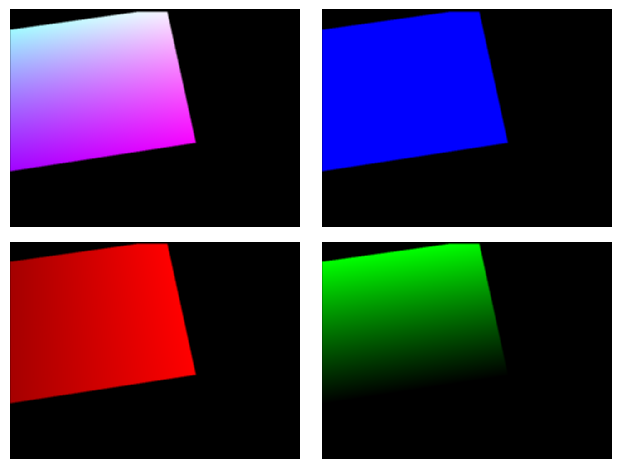

In [3]:
paths = glob.glob(f"../texcoords/v4-nodistort/*.png")
path = random.choice(paths)
print(path)

img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img.astype("float")

mask = img[:, :, 2] > 1
mask_indices = np.where(mask)

img = cv2.GaussianBlur(img, (5, 5), 3)
r, g, b = show_channels(img)

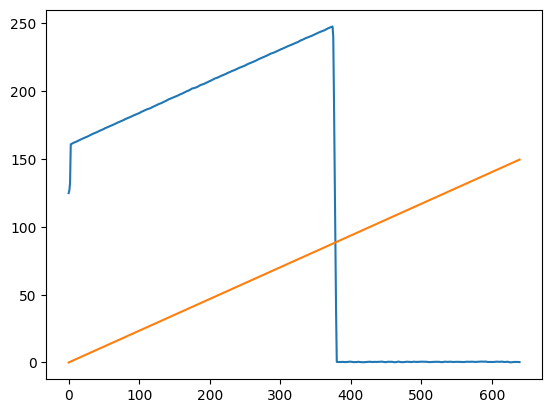

In [4]:
i = random.randint(0, 480)

slice_ = r[i]

x = np.arange(0, 640)
y = x * compute_gradient(r, y=i)

plt.plot(r[i])
plt.plot(x, y)

In [5]:
def method1():
    corners = {(0, 0): [], (0, 1): [], (1, 0): [], (1, 1): []}
    
    drdy_mean, drdx_mean = compute_gradient(r)
    dgdy_mean, dgdx_mean = compute_gradient(g)
    
    for ref in sample_random_points():
        predict_corners(corners, ref, drdx_mean, drdy_mean, dgdx_mean, dgdy_mean)
    
    return corners


def method2():
    corners = {(0, 0): [], (0, 1): [], (1, 0): [], (1, 1): []}

    for ref in sample_random_points(1000):
        x, y = ref

        if not in_keyboard(x=x):
            continue
        if not in_keyboard(y=y):
            continue

        drdx_mean = compute_gradient(r, y=y)
        drdy_mean = compute_gradient(r, x=x)
        dgdx_mean = compute_gradient(g, y=y)
        dgdy_mean = compute_gradient(g, x=x)

        predict_corners(corners, ref, drdx_mean, drdy_mean, dgdx_mean, dgdy_mean)

    return corners

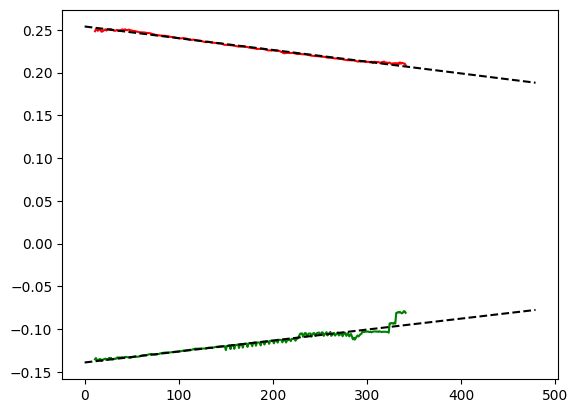

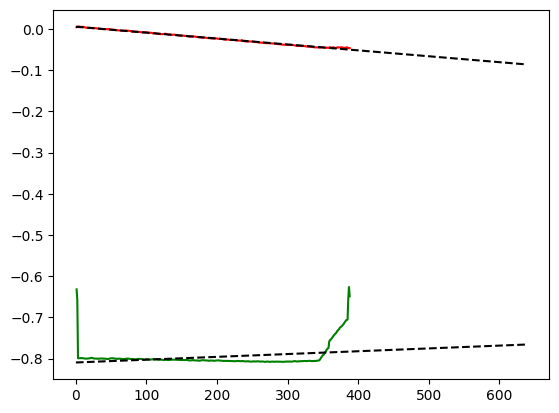

In [6]:
from sklearn.linear_model import LinearRegression

drdx_means = []
dgdx_means = []
drdy_means = []
dgdy_means = []

x = np.arange(0, 640)
y = np.arange(0, 480)

x_window = []
y_window = []
    
for i in y:
    if not in_keyboard(y=i):
        continue
        
    y_window.append(i)
    drdx_means.append(compute_gradient(r, y=i))
    dgdx_means.append(compute_gradient(g, y=i))

for i in x:
    if not in_keyboard(x=i):
        continue

    x_window.append(i)
    drdy_means.append(compute_gradient(r, x=i))
    dgdy_means.append(compute_gradient(g, x=i))   

x_window = np.array(x_window)[:, None]
y_window = np.array(y_window)[:, None]
x = x[:, None]
y = y[:, None]

drdx_fit = LinearRegression().fit(y_window, drdx_means)
dgdx_fit = LinearRegression().fit(y_window, dgdx_means)
drdy_fit = LinearRegression().fit(x_window, drdy_means)
dgdy_fit = LinearRegression().fit(x_window, dgdy_means)

plt.plot(y_window, drdx_means, c="r")
plt.plot(y_window, dgdx_means, c="g")
plt.plot(drdx_fit.predict(y), c="black", linestyle="--")
plt.plot(dgdx_fit.predict(y), c="black", linestyle="--")
plt.figure()

plt.plot(x_window, drdy_means, c="r")
plt.plot(x_window, dgdy_means, c="g")
plt.plot(drdy_fit.predict(x), c="black", linestyle="--")
plt.plot(dgdy_fit.predict(x), c="black", linestyle="--")

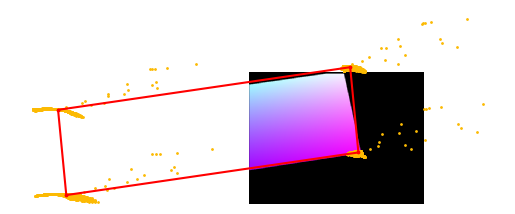

In [7]:
corners = {(0, 0): [], (0, 1): [], (1, 0): [], (1, 1): []}

for ref in sample_random_points():
    x = [[ref[0]]]
    y = [[ref[1]]]

    drdx_mean = drdx_fit.predict(y)[0]
    drdy_mean = drdy_fit.predict(x)[0]
    dgdx_mean = dgdx_fit.predict(y)[0]
    dgdy_mean = dgdy_fit.predict(x)[0]

    predict_corners(corners, ref, drdx_mean, drdy_mean, dgdx_mean, dgdy_mean)

plot_corners(corners)

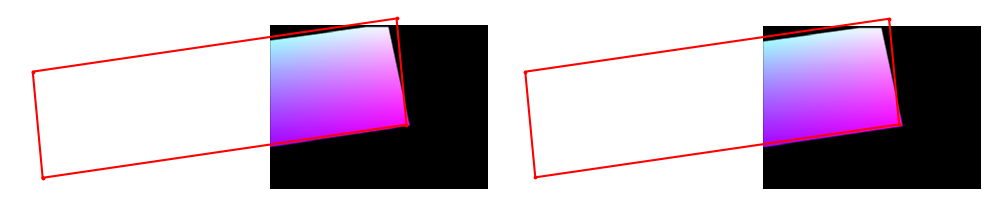

In [8]:
_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

corners = method1()
plot_corners(corners, ax=ax1, plot_raw=False)

corners = method2()
plot_corners(corners, ax=ax2, plot_raw=False)

plt.tight_layout()